# Vehicle Detection

Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

A PDF version of this report would be made available within this repository

## Histogram of Oriented Gradients (HOG)

**Explain how (and identify where in your code) you extracted HOG features from the training images.**

The code for this step is contained in the first code cell of the IPython notebook.

I started by reading in all the vehicle and non-vehicle images. 
The vehicle images are generously provided by GTI vehicle image database and the KITTI vision benchmark suite.

In order to get the images in, we would run the following commands in linux/mac environment

```
wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
unzip vehicles.zip
unzip non-vehicles.zip
```

Running the bash commands above would yield the vehicles and non-vehicles folders which would contain the images that would be used to train to identify vehicles in an image.

Here is an example of one of each of the vehicle and non-vehicle classes:

(64, 64, 3)


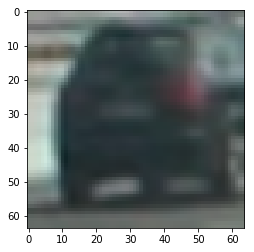

In [1]:
# Example Vehicle image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./vehicles/GTI_Left/image0019.png')
print(image.shape)
plt.imshow(image)

(64, 64, 3)


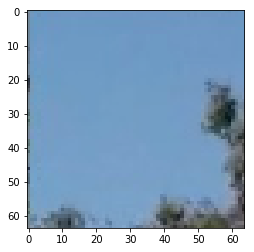

In [2]:
# Example Non-Vehicle image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./non-vehicles/Extras/extra1.png')
print(image.shape)
plt.imshow(image)

**Observation of Example Images**

Images are generally of 64 by 64 color images.

**Explain how you settled on your final choice of HOG parameters.**

Before selecting how the HOG parameters were decided on, we would first do some quick data exploration to determine what would be the best color channel to try to use HOG on. (HOG works on a single color channel). After which, we do some quick data exploration on the effects of the HOG parameters on the output of the HOG variable.

In [3]:
import cv2

# Defining color filters

def rgb_convert(image, filter=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    return image

def hls_convert(image, filter=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    return image

def gray_convert(image):
    '''
    Wrapper to easily reference to convert image to gray image
    '''
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [4]:
# Color images will be tested to see clarity of vehicle when compared to background
# We will be using one of the images from the dataset to see what the algorithm need
image_for_analysis = mpimg.imread('./vehicles/GTI_Left/image0009.png')

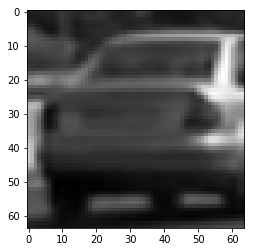

In [5]:
# Gray image
gray_image = gray_convert(image_for_analysis)
plt.imshow(gray_image, cmap='gray')

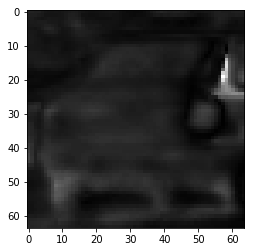

In [6]:
# Saturated image based on HLS color scheme
saturated_image = hls_convert(image_for_analysis, 's')
plt.imshow(saturated_image, cmap='gray')

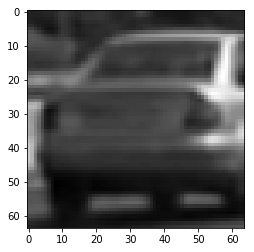

In [7]:
# Lightness image based on HLS color scheme
lightness_image = hls_convert(image_for_analysis, 'l')
plt.imshow(lightness_image, cmap='gray')

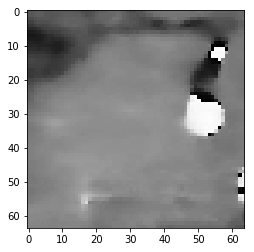

In [8]:
# Hue image based on HLS color scheme
hue_image = hls_convert(image_for_analysis, 'h')
plt.imshow(hue_image, cmap='gray')

**Observation**

We would not use RGB colors. Reason for this is that the car comes in various colors; e.g. Red, Blue, Green cars which means if we try to filter only for such channel, we could possibly lose out on all those mentioned colors. 

Based on the above, we would have a choice to choose either grayscale images on images based on lightness via HLS color scale. For simplicity purposes, we would just use grayscale this time.

In [9]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    '''
    Get Hog Features from image.
    :param img: Image has to be a single color channel image
    :param orient: Represents the number of orientation bins that the gradient information will be split up into in the histogram
    :param pix_per_cell: Specifies the cell size over which each gradient histogram is computed. 
    :param cell_per_block: Specifies the local area over which the histogram counts in a given cell will be normalized
    :param vis: A boolean that takes care whether to create outputs that can be used for vizualization purposes
    :param feature_vec: A boolean that takes where to convert an 'image-like' object can be converted to a single vector for use of training
    '''
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

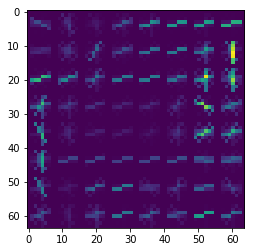

In [10]:
# Test out orient
orient_test_features, orient_test_hog_image = get_hog_features(gray_image, 9, 8, 2, vis=True)
plt.imshow(orient_test_hog_image)

**Observation**

We would proceed with the above settings of 9 for orient with 8 by 8 pixels per cell. Reason for supporting this is based of earlier research as mentioned within this wikipedia article.

https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

**Defining required feature extraction functions**

HOG would probably be one of the main important functions to use to identify whether an image contains a car or not - It somewhat get shape informaiton into the model. However, that is not the only way to tell whether the image contains a car or not. We can use color histograms and/or color spaces as well.

In [119]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
import numpy as np

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    features = img.ravel() # Remove this line!
    # Return the feature vector
    return features

In [120]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [121]:
# Define the feature extraction function to be used to classify the images
def extract_features(imgs):
     # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read the image file
        image = mpimg.imread(file)

        # Define the variables needed for using HOG
        # gray_image = gray_convert(image)
        # hog_features = get_hog_features(gray_image, orient=9, pix_per_cell=8, cell_per_block=2)

        # Define the color histograms that are to be used
        # color_hist_features = color_hist(image, cspace='HLS', nbins=32)
        extracted_features = single_img_features(image, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True)
        
        features.append(extracted_features)
    return features

Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using the above HOG features across the image dataset. 

From the code snippet below, we can see that number of images available for training is roughly the same which indicate a balanced dataset. With this, we won't need too much work to manipulate the data in order to balance the datasets.

In [122]:
# Import file names to prepare for training
import glob

non_vehicles_1 = glob.glob("./non-vehicles/Extras/*")
non_vehicles_2 = glob.glob("./non-vehicles/GTI/*")

vehicles_1 = glob.glob("./vehicles/GTI_Far/*")
vehicles_2 = glob.glob("./vehicles/GTI_Left/*")
vehicles_3 = glob.glob("./vehicles/GTI_MiddleClose/*")
vehicles_4 = glob.glob("./vehicles/GTI_Right/*")
vehicles_5 = glob.glob("./vehicles/KITTI_extracted/*")

non_vehicles = non_vehicles_1 + non_vehicles_2
vehicles = vehicles_1 + vehicles_2 + vehicles_3 + vehicles_4 + vehicles_5

print("No of non vehicle images: " + str(len(non_vehicles)))
print("No of vehicle images: " + str(len(vehicles)))

No of non vehicle images: 8968
No of vehicle images: 8792


In [123]:
# Image convert to features ~ 1 minute to run - Long running cell
import time

t=time.time()
print("Extraing vehicles for vehicles")
vehicle_features = extract_features(vehicles)
print("Extraing vehicles for non_vehicles")
non_vehicle_features = extract_features(non_vehicles)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

Extraing vehicles for vehicles
Extraing vehicles for non_vehicles
87.82 Seconds to extract HOG features...


In [124]:
# Before starting the training, we would need to do a test split
# This would allow us to validate our model's accuracy after the model training
# We don't need to do on the actual features yet, we can do it on the file names first

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Continue defining the features dataset
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.concatenate((np.ones(len(vehicles)), np.zeros(len(non_vehicle_features))))

# Get the X_train, X_test, y_train and y_test datasets
# We would define the random state statically to try to make the whole code repeatable and testable
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=10)

In [125]:
# Train model - Long running cell
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


18.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9792


## Sliding Window Search

**Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?**

There are several things to note when doing the sliding window search:

- We would want to ignore the bonnet that was recorded in the videos (Reduce the search space)
- Iteratively find for the car images with smaller and smaller window sizes. As the window size get smaller, we would find for such images closer and closer to the horizon
- An overlap of 50% could all possible spaces at least twice and would provide a stronger signal of finding the car when it is applied on a heat map
- Initial size would require us to first estimate using test images

(720, 1280, 3)


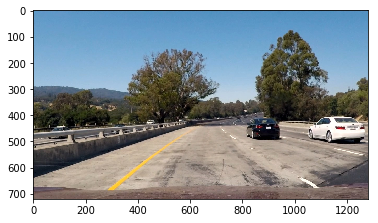

In [127]:
# Reading a sample test image

# Example Vehicle image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./test_images/test1.jpg')
print(image.shape)
plt.imshow(image)

From the above image, we would can use the halfway mark of the image (360 pixel mark) to the portion of the image near the bonnet at the 660 pixel mark. 

We will use the following window sizes

- 300 x 300 pixels
- 250 x 250 pixels
- 200 x 200 pixels
- 150 x 150 pixels
- 100 x 100 pixels

We are not making any assumption whether we are in the most left lane or right lane etc. This is why we would need to search across all of x to find the possibility of a car in the area of the image.

A quick test with bounding boxes smaller than 100 by 100 pixels show to be ineffective in detecting any car at all.

In [128]:
# Define additional required functions

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [129]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        # test_features = scaler.transform(np.array(features).reshape(1, -1))
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [130]:
# Get windows
overlap = (0.8, 0.8)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(300, 300), xy_overlap=overlap)
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(270, 270), xy_overlap=overlap)
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(230, 230), xy_overlap=overlap)
windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(200, 200), xy_overlap=overlap)
windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(170, 170), xy_overlap=overlap)
windows6 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(140, 140), xy_overlap=overlap)
windows7 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(120, 120), xy_overlap=overlap)
# This is for cars that are further away
windows8 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 660], 
                    xy_window=(100, 100), xy_overlap=overlap)
# windows5 = slide_window(image, x_start_stop=[None, None], y_start_stop=[360, 560], 
#                     xy_window=(64, 64), xy_overlap=overlap)

# Combine all windows together
windows.extend(windows2)
windows.extend(windows3)
windows.extend(windows4)
windows.extend(windows5)
windows.extend(windows6)
windows.extend(windows7)

print("No of windows identified: " + str(len(windows)))

No of windows identified: 971


Time (s) Taken to process a image: 3.7294554710388184


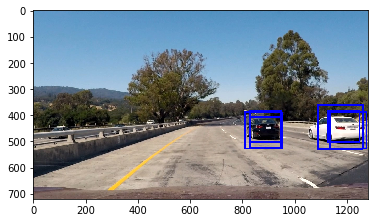

In [137]:
# Set all variables for easier reference
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

time_1 = time.time()

img = mpimg.imread("./test_images/test1.jpg")
draw_image = np.copy(img)

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

time_2 = time.time()
print("Time (s) Taken to process a image: " + str(time_2 - time_1))

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
plt.imshow(window_img)

**Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?**

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result. Here are some example images:

In [138]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [139]:
from scipy.ndimage.measurements import label

# Get heat image
img = mpimg.imread("./test_images/test1.jpg")
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Get box list
box_list = hot_windows

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

**Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

I recorded the positions of positive detections in each frame of the video. From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used scipy.ndimage.measurements.label() to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. I constructed bounding boxes to cover the area of each blob detected.

However, there were very few instances of such mislabelling. At the same time, the model could only detect the models quite rarely, which makes it difficult to properly pinpoint the vehicle. Hence, I went ahead with trying to ignore "use" false positives. The video generated below seems to indicate that it was still ok to utilize it.

Here's an example result showing the heatmap from a series of frames of video, the result of scipy.ndimage.measurements.label() and the bounding boxes then overlaid on the last frame of video:

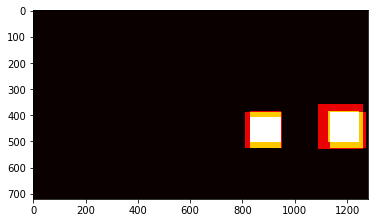

In [140]:
plt.imshow(heatmap, cmap='hot')

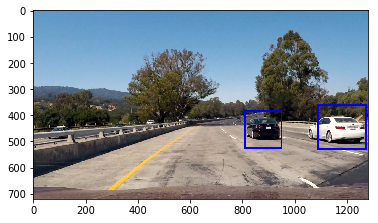

In [141]:
plt.imshow(draw_img)

## Video Implementation

**Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

In [142]:
# Code to generate video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [143]:
# Some of the variables have to be obtained from the environment
def process_image(img):
    
    draw_image = np.copy(img)

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat) 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Get box list
    box_list = hot_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return(draw_img)

In [144]:
video_output = 'vehicle_detection_output.mp4'
clip1 = VideoFileClip("project_video.mp4") # Input
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video vehicle_detection_output.mp4
[MoviePy] Writing video vehicle_detection_output.mp4



100%|█████████▉| 1260/1261 [1:21:49<00:03,  3.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection_output.mp4 

CPU times: user 1h 20min 19s, sys: 1min 18s, total: 1h 21min 38s
Wall time: 1h 21min 50s


In [145]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

# Problems/Issues for current implementation

The following algorithm implemented above may roughly work in some cases but it could possibly fail in the following scenarios.

- Various weather conditions. This makes it hard to make out the shape of other vehicles as the rainy whether would add noise to the image. 
- Various different makes of cars. If car's shapes change over the course of the year and if that wasn't really part of the image bank that was used to train the model, that would mean that the model wasn't train on that and it would probably ignore that shape as being defined as a car
- Current implementation above is quite slow which makes it impossible to be used immediately. It would create plenty of code tweaking to optimize the speed to make it generate the video at get information of the possible location of the cars so that the algorithm can work near real time.